In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as cm
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import scipy.integrate as scint 

In [4]:
#read the experimental data from the csv file
p5_1 = pd.read_csv('../Data/5prime/5p1 raw.csv')
p5_2 = pd.read_csv('../Data/5prime/5p2 raw.csv')
p5_3 = pd.read_csv('../Data/5prime/5p3 raw.csv')
p5_4 = pd.read_csv('../Data/5prime/5p4 raw.csv')
p5_6 = pd.read_csv('../Data/5prime/5p6 raw.csv')

#read the positive control data from the csv file
FAM_decay = pd.read_csv('../Data/controls/FAM_decay.csv')

#read the initial signal data from the csv file
initial_signal = pd.read_csv('../Data/controls/initial_signal.csv')

#convert data to numpy arrays
p5_1 = np.array(p5_1)
p5_2 = np.array(p5_2)
p5_3 = np.array(p5_3)
p5_4 = np.array(p5_4)
p5_6 = np.array(p5_6)

FAM_decay = np.array(FAM_decay)
initial_signal = np.array(initial_signal)

In [15]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_eff):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I = concs_init[0]
    S = concs_init[1]
    SI = concs_init[2]
    O = concs_init[3]
    FQ = concs_init[4]
    OQ = concs_init[5]
    F = concs_init[6]
    
    k_rep = 10**5.0299330881810995
    
    dI_dt = -k_eff*I*S
    dSI_dt = -dI_dt
    dS_dt = dI_dt
    
    dO_dt = k_eff*I*S - k_rep*O*FQ
    
    dOQ_dt = k_rep*O*FQ 
    dFQ_dt = - dOQ_dt 
    dF_dt = dOQ_dt
    
    return [dI_dt, dS_dt, dSI_dt, dO_dt, dFQ_dt,dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_eff, alpha):
    """SOLVES A SYSTEM OF ODES THROUGH NUMERICAL INTEGRATION
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param alpha: scaling constant
    :type alpha: int, float
    :return: numerical integration for the concentration of the fluorescently-labelled single strand over time"""
    I_init = alpha*60*10**-9
    S_init = alpha*60*10**-9 
    SI_init = 0 
    O_init = 0 
    FQ_init = alpha*60*10**-9
    OQ_init = 0 
    F_init = 0 
    
    concs_init = [I_init, S_init, SI_init, O_init, FQ_init, OQ_init, F_init]
    
    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_eff,), hmax = 20)
    return soln[:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    #popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,5,0.8], bounds=([1., 4.5, 0],[7.,5.5, 1.]))   
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,0.8], bounds=([1., 0],[8., 1.]))   
    return popt, pcov

keff =  2.2285230661657787
alpha =  0.9999999999999999
[[ 0.1455124  -0.16045926]
 [-0.16045926  0.17695013]]
[0.38146088 0.42065441]
keff =  4.723091884633558
alpha =  0.285026115388919
[[ 1.47332924e-04 -1.80176737e-05]
 [-1.80176737e-05  2.29438580e-06]]
[0.01213808 0.00151472]
keff =  4.524726422039438
alpha =  0.6990978843472401
[[ 6.51008800e-06 -1.66028465e-06]
 [-1.66028465e-06  4.65198109e-07]]
[0.00255149 0.00068205]
keff =  5.160858141850681
alpha =  0.7612842670730039
[[ 1.16216674e-06 -1.20531696e-07]
 [-1.20531696e-07  1.77541596e-08]]
[0.00107804 0.00013324]
keff =  7.326197621825315
alpha =  0.7556423987363955
[[ 1.01347693e-02 -1.43021062e-05]
 [-1.43021062e-05  9.55127272e-08]]
[0.10067159 0.00030905]


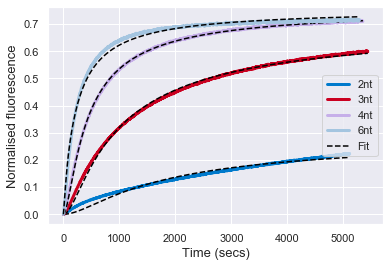

In [16]:
#average across the three replicates
sns.set()
plt.figure()
color = ['red','#007acc', '#ca0020','#c6afe9', '#a4c5e0']
labels = ['1nt', '2nt', '3nt', '4nt', '6nt']
toehold_lengths = [p5_1, p5_2, p5_3, p5_4, p5_6]
#loop through the TMSD experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time5p = np.empty((len(th_len[:, 0]), 5))
    p5_fluor = np.empty((len(th_len[:, 0]), 5))
    
    #fill the matrices the with the data for the TMSD experiments
    time5p[:, ind] = th_len[:,0]
    p5_fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    
    FAM_decay_time = FAM_decay[:, 0].tolist()
    time5p_time = time5p[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time5p[0, ind]:     
        start_time = FAM_decay_time.index(time5p[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time5p[-1, ind]:
            p5_molar_fluor = np.empty((len(th_len[:, 0]), 5))
            end_time = FAM_decay_time.index(time5p[-1, ind])
            p5_molar_fluor[:, ind] = (np.subtract(p5_fluor[:, ind], p5_fluor[0, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], p5_fluor[0, ind]))
            time5p_molar = np.subtract(time5p[:, ind], time5p[0, ind])
        else:
            p5_molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 5))
            end_time = time5p_time.index(FAM_decay[-1, 0])
            p5_molar_fluor[:, ind] = (np.subtract(p5_fluor[:end_time+1, ind], p5_fluor[0, ind]))/(np.subtract(FAM_decay[start_time:, 1], p5_fluor[0, ind]))
            time5p_molar = np.subtract(time5p[:end_time + 1, ind], time5p[0, ind])
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time5p_time.index(FAM_decay[0, 0])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time5p[-1, ind]:
            p5_molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 5))
            end_time = FAM_decay_time.index(time5p[-1, ind])
            p5_molar_fluor[:, ind] = (np.subtract(p5_fluor[start_time:, ind], p5_fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], p5_fluor[start_time, ind]))
            time5p_molar = np.subtract(time5p[start_time:, ind], time5p[start_time, ind])
        else:
            p5_molar_fluor = np.empty((len(FAM_decay[:, 0]), 5))
            end_time = time5p_time.index(FAM_decay[-1, 0])
            p5_molar_fluor[:, ind] = (np.subtract(p5_fluor[start_time:end_time+1, ind], p5_fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:, 1], p5_fluor[start_time, ind])) 
            time5p_molar = np.subtract(time5p[start_time:end_time+1, ind], time5p[start_time, ind])
            
    '''#plot the average fluorescence against time
    plt.plot(time5p[:, ind], p5_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()

    #plot the average normalised fluorescence against time
    plt.plot(time5p_molar, p5_molar_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()'''
    
    #fit the experimental data to the bimolecular model using numerical integration
    popt, pcov = fit_TMSD(time5p_molar, p5_molar_fluor[:, ind])
    print('keff = ', popt[0])
    print('alpha = ', popt[1])
    print(pcov)
    #determine one standard deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)
    TMSD_sol = solve_TMSD(time5p_molar, *popt)
    
    #plot the numerical integration and the fits
    if ind in range(1, 5):
        plt.plot(time5p_molar, p5_molar_fluor[:, ind], color[ind], linewidth = 3, label = labels[ind])
        if ind == 1:
            plt.plot(time5p_molar, TMSD_sol, '--', c = 'black', label = 'Fit')
        else: 
            plt.plot(time5p_molar, TMSD_sol, '--', c = 'black')
        
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[3], handles[4], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[4], labels[1]]
ax.legend(handles,labels,loc='center right')

plt.xlabel('Time (secs)', fontsize = 13, fontname = 'Arial')
plt.ylabel('Normalised fluorescence', fontsize = 13, fontname = 'Arial')
plt.savefig('5prime keff fixed_krep no_init.svg')

plt.show()